# Evidencia Portafolio

Momento de Retroalimentación: Módulo 2 Implementación de un modelo de deep learning. (Portafolio Implementación)

Por: Alan Contreras Prieto - A01749667

In [13]:
%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [14]:
#pip install 

In [ ]:
#import funcionesIA as f_IA
from funcionesIA import *
import pandas as pd
import seaborn as sns
import numpy as np
import matplotlib.pyplot as plt

from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_absolute_error

import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense, Dropout
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import EarlyStopping


# Introducción: 
Planteamiento del problema que se busca resolver, así como su relevancia.


# Datos: 


## Descripción (incluyendo fuente)
> terminar


Link: https://github.com/zhouhaoyi/ETDataset/tree/main?tab=readme-ov-file


Créditos:
@inproceedings{haoyietal-informer-2021,
  author    = {Haoyi Zhou and
               Shanghang Zhang and
               Jieqi Peng and
               Shuai Zhang and
               Jianxin Li and
               Hui Xiong and
               Wancai Zhang},
  title     = {Informer: Beyond Efficient Transformer for Long Sequence Time-Series Forecasting},
  booktitle = {The Thirty-Fifth {AAAI} Conference on Artificial Intelligence, {AAAI} 2021, Virtual Conference},
  volume    = {35},
  number    = {12},
  pages     = {11106--11115},
  publisher = {{AAAI} Press},
  year      = {2021},
}

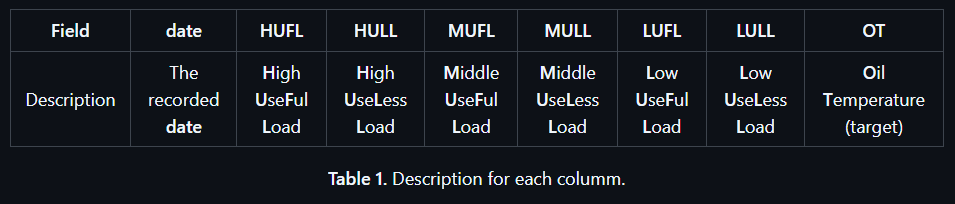

In [16]:
data = pd.read_csv("data/ETTm2.csv")
data['date'] = pd.to_datetime(data['date'])
data.set_index('date', inplace=True)
data

,HUFL,HULL,MUFL,MULL,LUFL,LULL,OT
date,,,,,,,
2016-07-01 00:00:00,41.130001,12.481,36.535999,9.355,4.424,1.311,38.661999
2016-07-01 00:15:00,39.622002,11.309,35.543999,8.551,3.209,1.258,38.223000
2016-07-01 00:30:00,38.868000,10.555,34.365002,7.586,4.435,1.258,37.344002
2016-07-01 00:45:00,35.518002,9.214,32.569000,8.712,4.435,1.215,37.124001
2016-07-01 01:00:00,37.528000,10.136,33.936001,7.532,4.435,1.215,37.124001
...,...,...,...,...,...,...,...
2018-06-26 18:45:00,42.722000,12.230,54.014000,12.652,-11.525,-1.418,45.986500
2018-06-26 19:00:00,38.868000,10.052,49.859001,10.669,-11.525,-1.418,45.986500
2018-06-26 19:15:00,39.622002,11.057,50.448002,11.795,-10.299,-1.418,45.546501


## Análisis

In [17]:
print(data.info())
data.describe()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 69680 entries, 2016-07-01 00:00:00 to 2018-06-26 19:45:00
Data columns (total 7 columns):
 #   Column  Non-Null Count  Dtype  
---  ------  --------------  -----  
 0   HUFL    69680 non-null  float64
 1   HULL    69680 non-null  float64
 2   MUFL    69680 non-null  float64
 3   MULL    69680 non-null  float64
 4   LUFL    69680 non-null  float64
 5   LULL    69680 non-null  float64
 6   OT      69680 non-null  float64
dtypes: float64(7)
memory usage: 4.3 MB
None


,HUFL,HULL,MUFL,MULL,LUFL,LULL,OT
count,69680.000000,69680.000000,69680.000000,69680.000000,69680.000000,69680.000000,69680.000000
mean,37.219411,8.554209,43.861438,8.340187,-3.430701,-2.084888,26.609799
std,10.243442,6.031270,13.061909,4.369039,6.154438,6.013584,11.886536
min,0.000000,-29.319000,10.427000,-6.648000,-14.617000,-31.462000,-2.646500
25%,30.156000,4.523000,37.421001,5.656000,-9.286000,-2.505000,16.469500
50%,37.277000,9.131000,41.415001,9.328000,-3.774000,-1.226000,26.577000
75%,44.146000,13.235000,46.186001,11.285000,2.527000,0.000000,35.585999
max,107.892998,36.438999,93.230003,29.808001,17.218000,3.731000,58.876999


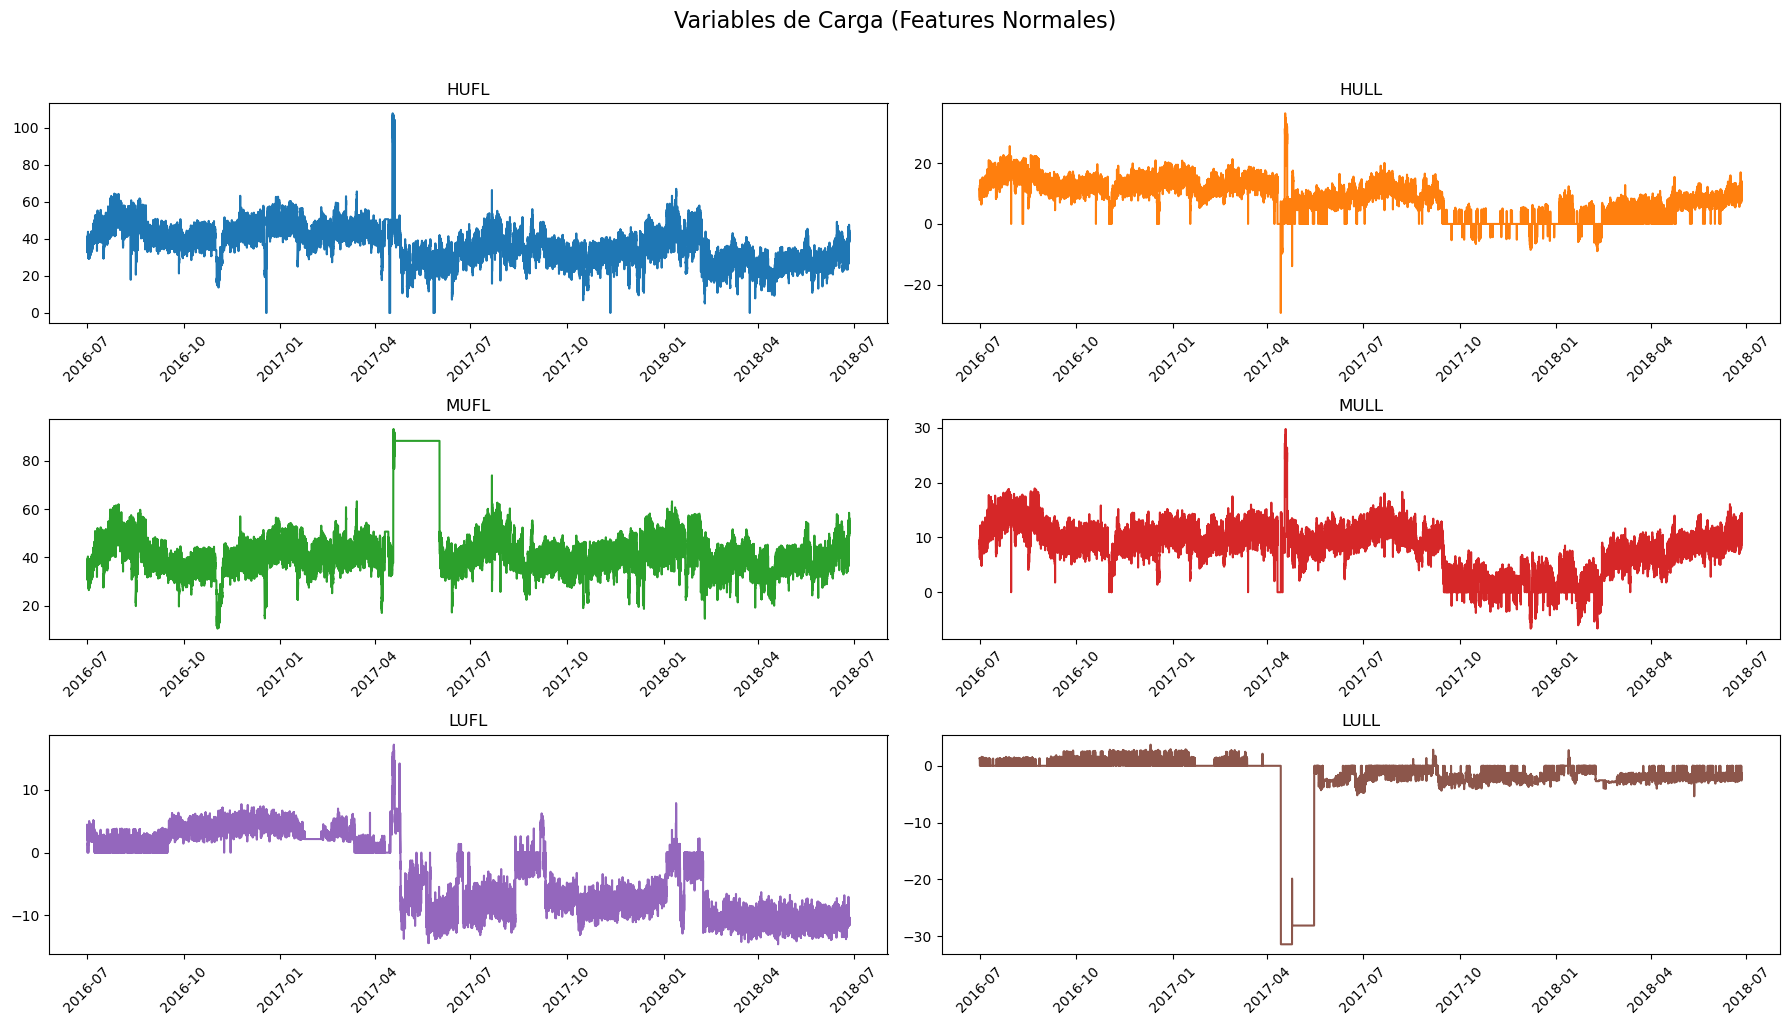

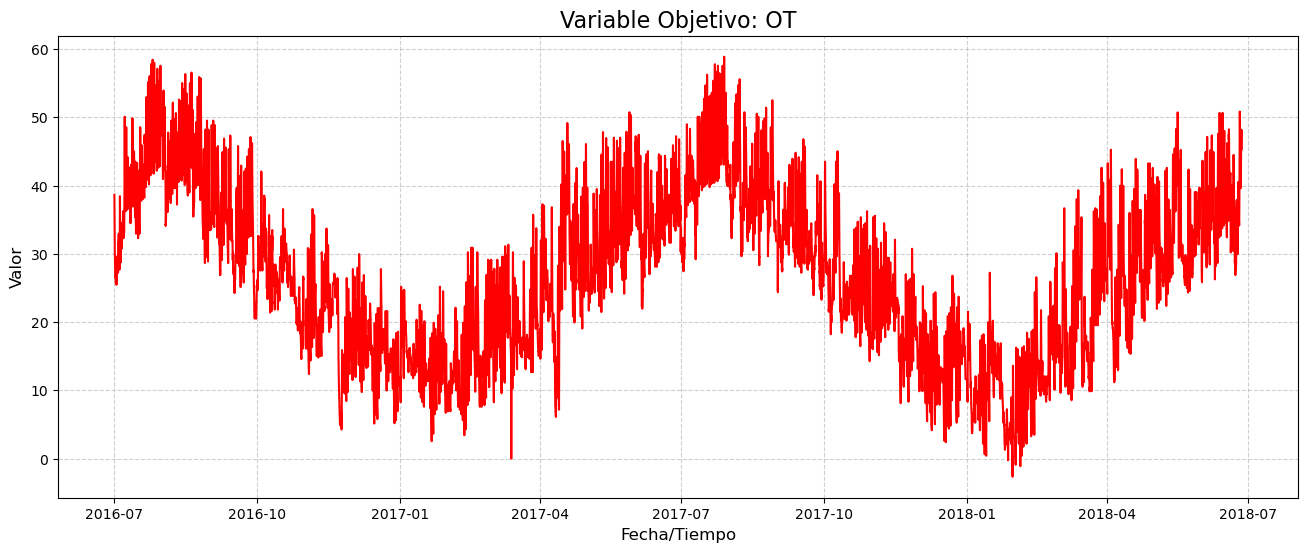

In [18]:
feature_cols = ['HUFL', 'HULL', 'MUFL', 'MULL', 'LUFL', 'LULL']
target_col   = 'OT'
plot_time_series(data, feature_cols, target_col)

## Separación en entrenamiento y prueba

In [19]:
data = add_time_features(data)
X = data.drop(columns=[target_col])
y = data[target_col]
X_train, X_valid, X_test, y_train, y_valid, y_test = train_valid_test_split(X, y, test_size=0.25, valid_size=0.4)
X_train.shape, X_valid.shape, X_test.shape

((52260, 18), (10452, 18), (6968, 18))

## Preprocesamiento

## Escalado

In [20]:
res = scale_data(X_train, X_valid, X_test, y_train, y_valid, y_test)
X_train_s, X_valid_s, X_test_s, y_train_s, y_valid_s, y_test_s, x_scaler, y_scaler = res

## Sequencias

In [21]:
SEQUENCE_LENGTH = 96 # 1 Full day = 24 hours * 4 (15 min intervals)
X_train_seq, y_train_seq = create_sequences(X_train_s, y_train_s, SEQUENCE_LENGTH)
X_valid_seq, y_valid_seq = create_sequences(X_valid_s, y_valid_s, SEQUENCE_LENGTH)
X_test_seq, y_test_seq = create_sequences(X_test_s, y_test_s, SEQUENCE_LENGTH)
X_train_seq.shape, y_train_seq.shape, X_valid_seq.shape, y_valid_seq.shape, X_test_seq.shape, y_test_seq.shape

((52164, 96, 18), (52164,), (10356, 96, 18), (10356,), (6872, 96, 18), (6872,))

In [22]:
N_FEATURES = X_train_seq.shape[2]  # Número total de features (cargas + temporales)

# Desarrollo del modelo: 
Descripción de la arquitectura empleada, entrenamiento y evaluación de resultados.


# Construcción del Modelo

In [ ]:
def build_lstm_model(seq_len, n_feat):
    model = Sequential([
        # 1. Capa LSTM (Unidad especializada)
        LSTM(units=128, 
             input_shape=(seq_len, n_feat),
             return_sequences=True, #=True permite apilar otra capa LSTM.
             dropout=0.2, # Evita que la capa LSTM memorize el ruido
             recurrent_dropout=0.2), 
        
        # 2. Segunda Capa LSTM (para modelar patrones más complejos/jerárquicos)
        LSTM(units=64,
             return_sequences=False, #=False en la última capa LSTM para pasar a capas Dense
             dropout=0.2,
             recurrent_dropout=0.2), 
        
        # 3. Capa de Regularización
        Dropout(0.3), 
        
        # Capa Densa Final (Output)
        Dense(units=1)
    ])
    return model

lstm_model = build_lstm_model(SEQUENCE_LENGTH, N_FEATURES)

c:\ProgramData\miniconda3\envs\ARIMA\Lib\site-packages\keras\src\layers\rnn\rnn.py:199: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


In [ ]:
optimizer = Adam(learning_rate=0.001)

lstm_model.compile(
    optimizer=optimizer,
    loss='mean_squared_error', # Para regresión
    metrics=['mean_absolute_error'] # Métrica más interpretable
)

lstm_model.summary()

Model: "sequential_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ lstm_2 (LSTM)                   │ (None, 96, 128)        │        75,264 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ lstm_3 (LSTM)                   │ (None, 64)             │        49,408 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_1 (Dropout)             │ (None, 64)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 1)              │            65 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 124,737 (487.25 KB)

 Trainable params: 124,737 (487.25 KB)

 Non-trainable params: 0 (0.00 B)

In [ ]:
# Early Stopping para detener el entrenamiento si la pérdida de validación deja de mejorar para evitar overfitting
early_stop = EarlyStopping(
    monitor='val_loss',         # Monitorea la pérdida de validación
    patience=10,                # Número de épocas sin mejora antes de detener
    restore_best_weights=True   # Mantiene los mejores pesos encontrados
)

history = lstm_model.fit(
    X_train_seq, 
    y_train_seq, 
    epochs=100,                 # Un número alto, ya que Early Stopping lo detendrá
    batch_size=32,
    validation_data=(X_valid_seq, y_valid_seq),
    callbacks=[early_stop] 
)

Epoch 1/100
1631/1631 ━━━━━━━━━━━━━━━━━━━━ 178s 106ms/step - loss: 0.0133 - mean_absolute_error: 0.0892 - val_loss: 0.0139 - val_mean_absolute_error: 0.0957
Epoch 2/100
1631/1631 ━━━━━━━━━━━━━━━━━━━━ 164s 101ms/step - loss: 0.0081 - mean_absolute_error: 0.0716 - val_loss: 0.0152 - val_mean_absolute_error: 0.1036
Epoch 3/100
1631/1631 ━━━━━━━━━━━━━━━━━━━━ 190s 116ms/step - loss: 0.0071 - mean_absolute_error: 0.0672 - val_loss: 0.0130 - val_mean_absolute_error: 0.0947
Epoch 4/100
1631/1631 ━━━━━━━━━━━━━━━━━━━━ 188s 115ms/step - loss: 0.0066 - mean_absolute_error: 0.0648 - val_loss: 0.0124 - val_mean_absolute_error: 0.0919
Epoch 5/100
1631/1631 ━━━━━━━━━━━━━━━━━━━━ 186s 114ms/step - loss: 0.0062 - mean_absolute_error: 0.0626 - val_loss: 0.0142 - val_mean_absolute_error: 0.0996
Epoch 6/100
1631/1631 ━━━━━━━━━━━━━━━━━━━━ 185s 114ms/step - loss: 0.0059 - mean_absolute_error: 0.0609 - val_loss: 0.0126 - val_mean_absolute_error: 0.0916
Epoch 7/100
1631/1631 ━━━━━━━━━━━━━━━━━━━━ 186s 114ms/step

# Ajuste del modelo: 
Ajuste de hiperparámetros/cambios en arquitectura para mejorar resultados previos (al menos una iteración).

# Resultados: 
Evaluación de modelo final con datos de prueba.


In [ ]:
print("Evaluando el modelo en el conjunto de prueba...")
test_loss, test_mae = lstm_model.evaluate(X_test_seq, y_test_seq, verbose=0)

print(f"\n--- Resultados de la Prueba ---")
# El error está en la escala escalada (0 a 1)
print(f"Pérdida (MSE) en Test (escalado): {test_loss:.6f}")
print(f"Error Absoluto Medio (MAE) en Test (escalado): {test_mae:.6f}")

Evaluando el modelo en el conjunto de prueba...

--- Resultados de la Prueba ---
Pérdida (MSE) en Test (escalado): 0.007420
Error Absoluto Medio (MAE) en Test (escalado): 0.067658


In [ ]:
# 1. Generar Predicciones (Aún en la escala de 0 a 1)
y_pred_scaled = lstm_model.predict(X_test_seq).flatten()

# 2. Desescalar 
y_pred = y_scaler.inverse_transform(y_pred_scaled.reshape(-1, 1)).flatten()
y_true = y_scaler.inverse_transform(y_test_seq.reshape(-1, 1)).flatten()

215/215 ━━━━━━━━━━━━━━━━━━━━ 4s 20ms/step
MAE en la escala Real: 3.98


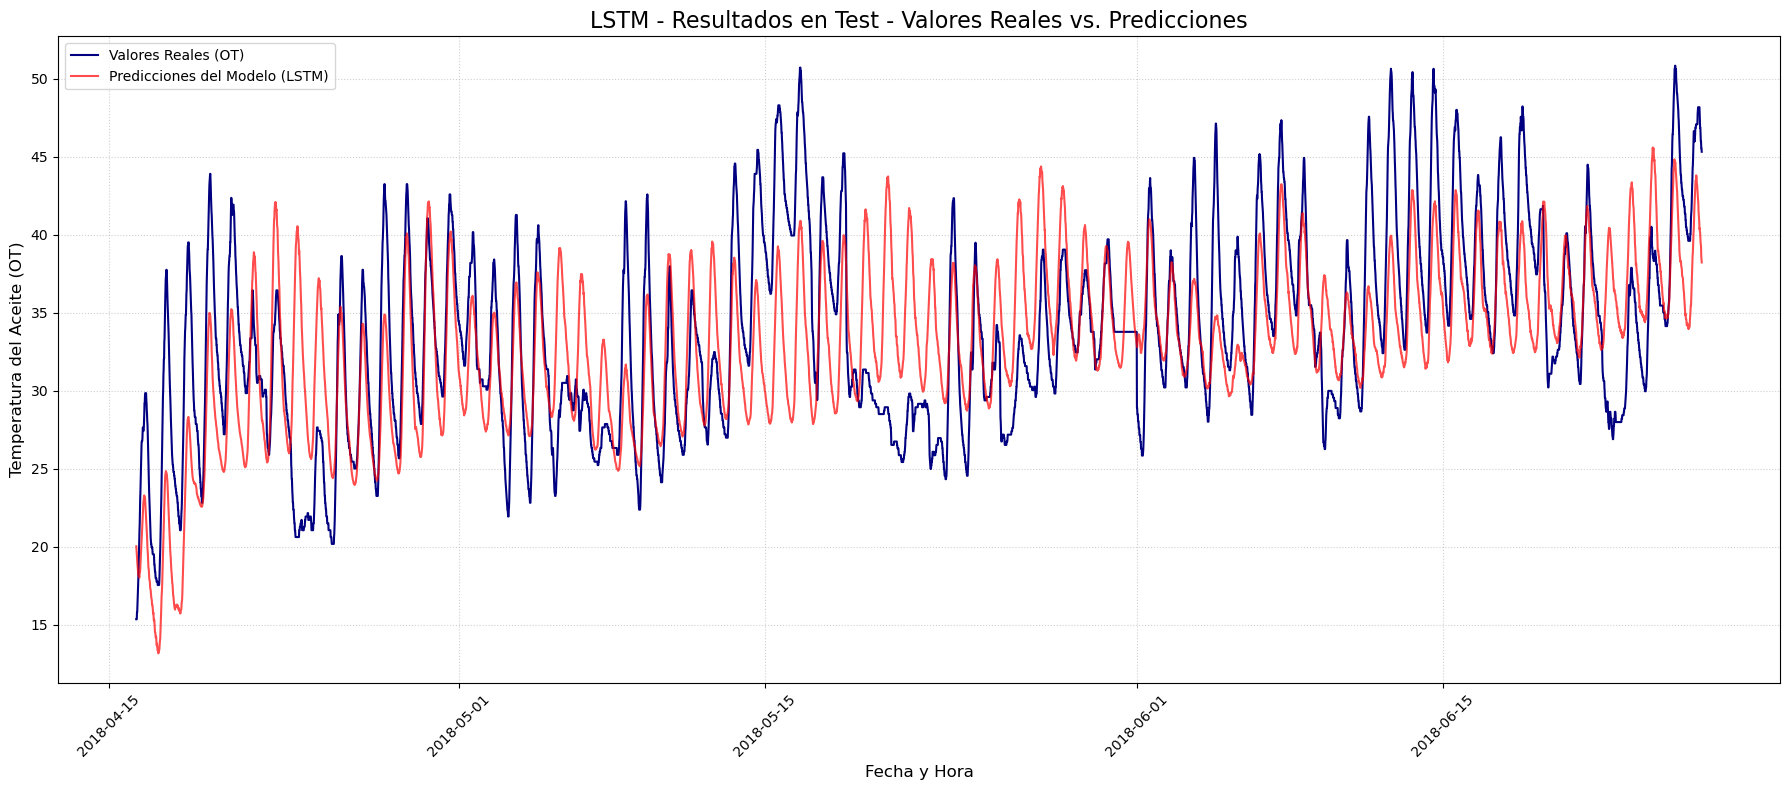

MAE en la escala Real: 3.98


In [61]:
plot_predictions(y_true, y_pred, data.index[-len(y_true):], title_prefix="LSTM - Resultados en Test")
mae_real = mean_absolute_error(y_true, y_pred)
print(f"MAE en la escala Real: {mae_real:.2f}")

# Conclusiones: 
Análisis de los resultados obtenidos, identificación de posibles áreas de mejora.


# Aplicación: 
Función para probar modelo con datos nuevos (por ejemplo, argumento=ruta a imagen, salida=resultado de clasificación).
